# DBSCAN
---

In [1]:
%matplotlib notebook

## Imports

In [2]:
import math
import matplotlib.colors as mcolors
import matplotlib.markers as mmarkers

from collections import Counter
from itertools import chain, groupby, zip_longest 
from matplotlib import pyplot as plt
from operator import itemgetter
from random import randrange, random, sample
from scipy.spatial import KDTree
from statistics import mean

from typing import Callable, List, Tuple

## Algorithm

In [3]:
NOISE = -1 

def dbscan(points: List[Tuple], eps: float, min_points: int) -> List[int]:
    """DBSCAN clustering.

    Args:
        points: A list of points to cluster.
        eps: The radius `epsilon` of the dense regions.
        min_points: The minimum number of points that needs to be within a distance `eps` for a point to be a core point.

    Returns:
        A list of the cluster indices for each point.
    """

    cluster_indices = [None for _ in points]
    current_index = 0
    kd_tree = KDTree(points)
    for i in range(len(points)):
        if cluster_indices[i] is not None:
            continue
        process_set = {i}
        cluster_indices[i] = NOISE
        current_index += 1
        while len(process_set) > 0:
            j = process_set.pop()
            _, neighbors = kd_tree.query(points[j], k=None, distance_upper_bound=eps)
            if len(neighbors) < min_points:
                continue
            cluster_indices[j] = current_index
            process_set |= set(filter(lambda p: cluster_indices[p] is None or (p != j and cluster_indices[p] == NOISE),
                                  neighbors))
    return cluster_indices

## Dataset Creation

In [4]:
def create_spherical_cluster(centroid, radius, n_points):
    def random_point_in_circle():
        alpha = random() * 2 * math.pi
        r = radius * math.sqrt(random())
        # r is dim-dimensional root of radius
        
        x = centroid[0] + r * math.cos(alpha)
        y = centroid[1] + r * math.sin(alpha)
        return (x, y)
                    
    return [random_point_in_circle() for _ in range(n_points)] 

In [5]:
def create_ring_cluster(centroid, inner_radius, outer_radius, n_points):
    def random_point_in_ring():
        alpha = random() * 2 * math.pi
        r = inner_radius + (outer_radius - inner_radius) * math.sqrt(random())
        # r is dim-dimensional root of radius
        
        x = centroid[0] + r * math.cos(alpha)
        y = centroid[1] + r * math.sin(alpha)
        return (x, y)
                    
    return [random_point_in_ring() for _ in range(n_points)]

In [6]:
def create_linear_cluster(centroid, length, n_points, alpha=0):
    delta = length / n_points
    step = 0.
    
    def random_point_in_segment(step, displacement_x):
        x = centroid[0] + step * math.cos(alpha) + displacement_x
        y = centroid[1] + step * math.sin(alpha)
        return (x, y)

    points = []
    for i in range(n_points):
        step += (0.5 + random() / 2) * delta
        for _ in range(randrange(1, 10)):
            displacement_x = random() * delta * 2 - delta
            points.append(random_point_in_segment(step, displacement_x))
            
    return points

In [7]:
def create_spiral_cluster(centroid, radius, n_points):
    a_delta = 10 * math.pi / n_points
    r_delta = radius / n_points  
    s = math.sqrt(radius)

    def random_point_in_spiral(index, alpha):
        x = centroid[0] + index * r_delta * (0.95 + random() * 0.1) * math.cos(alpha) #+ (random() * s - s)
        y = centroid[1] + index * r_delta * (0.95 + random() * 0.1) * math.sin(alpha) #+ (random() * s - s)
        return (x, y)
    
    
    alpha = 0.
    radius = 0.
    points = []
    for i in range(n_points):
        step = 0.1 + random() * 0.4
        alpha += a_delta * step
        for _ in range(randrange(1, 10)):
            points.append(random_point_in_spiral(i, alpha))
            step = random() * 0.1
            alpha += a_delta * step
    return points 

In [8]:
def random_point(radius):
    return (random() * radius - radius / 2, random() * radius - radius / 2)

## Plotting

In [9]:
def __group_points_by_cluster(points: List[Tuple], cluster_indices: List[int]) -> List[List[Tuple]]:
    """Takes a list of points and another list with their cluster_indices, groups the points by cluster_indices and
       returns the list of points.

    Args:
        points: The list of points to group.
        cluster_indices: The list of cluster indices for the points. Must reflect the order of `points`.

    Returns:
        A list of clusters, where each cluster is a list of points.
    """
    n = len(points)
    get_point_label = lambda i: cluster_indices[i]
    clusters = groupby(sorted(range(n), key=get_point_label), key=get_point_label)
    return [[points[i] for i in group] for _, group in clusters]

In [72]:
def plot_points(ax, points, color, marker='o'):
    X, Y = zip(*points)
    ax.plot(X, Y, marker=marker, linestyle='none', markersize=8, markerfacecolor=color, markeredgewidth=1, markeredgecolor='k')

    
def plot_clusters(points, labels, point_markers=[]):
    fig, ax = plt.subplots()
    fig.suptitle('DBSCAN')
    ax.set_aspect('equal')
    fig.canvas.draw()
    clusters = __group_points_by_cluster(points, labels)
    if -1 in labels:
        point_markers = ['x'] + point_markers
    k = len(clusters)
    colors = list(mcolors.TABLEAU_COLORS.keys())[:k]
    point_markers = point_markers[:k]
    for cluster, color, marker in zip_longest(clusters, colors, point_markers, fillvalue='o'):
        plot_points(ax, cluster, color, marker)

## Experiments
---

### Spherical Clusters

In [11]:
k = 10
data_centroids = [random_point(10) for _ in range(k)]
data_clusters = [create_spherical_cluster(P, 0.25 + random(), randrange(10, 100)) for P in data_centroids]
noise = [random_point(10) for _ in range(50)]


points = [p for C in data_clusters for p in C] + noise

<IPython.core.display.Javascript object>


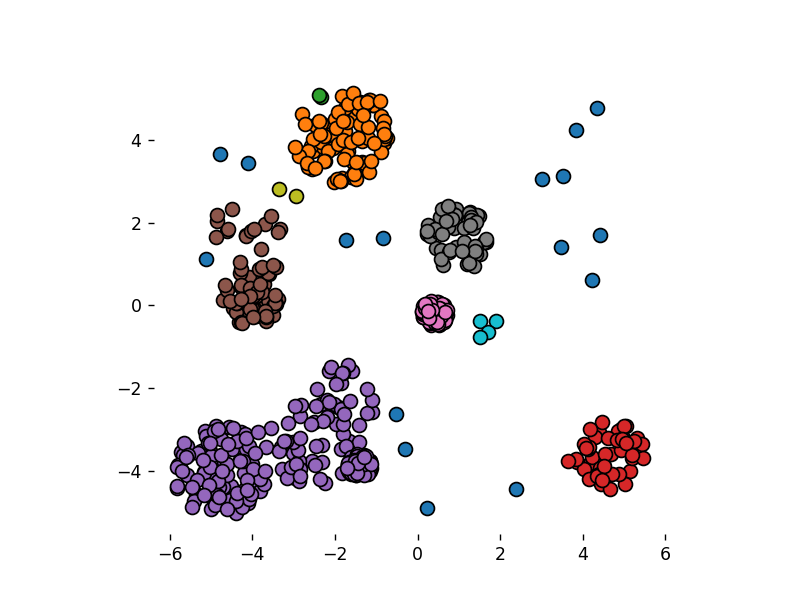

In [12]:
labels = dbscan(points, 0.5, 2)

plot_clusters(points, labels)

In [21]:
s = {1}
s |= {1,2}
print(s)

{1, 2}


### Rings

In [26]:
data_centroid = random_point(10)

r1 = 0.25 + random()
r2 = r1 + 0.25 * random()
r3 = r2 * 1.1 + random()
r4 = r3 + 0.25 * random()

C1 = create_ring_cluster(data_centroid, r1, r2, randrange(100, 200))
C2 = create_ring_cluster(data_centroid, r3, r4, randrange(200, 300))

points = C1 + C2

In [121]:
labels_1 = dbscan(points, 0.5, 3)

<IPython.core.display.Javascript object>


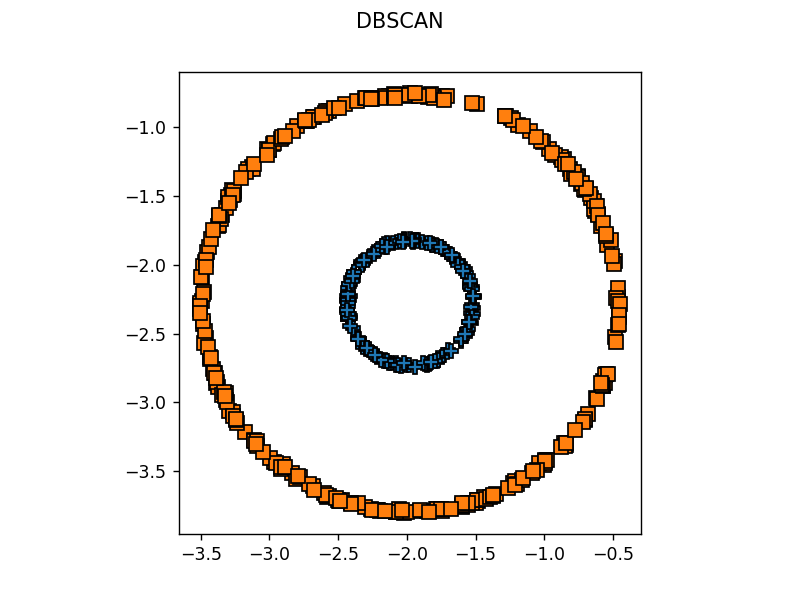

In [122]:
plot_clusters(points, labels_1, ['P', 's', 'o'])

In [123]:
labels_2 = dbscan(points, 0.1, 3)

<IPython.core.display.Javascript object>


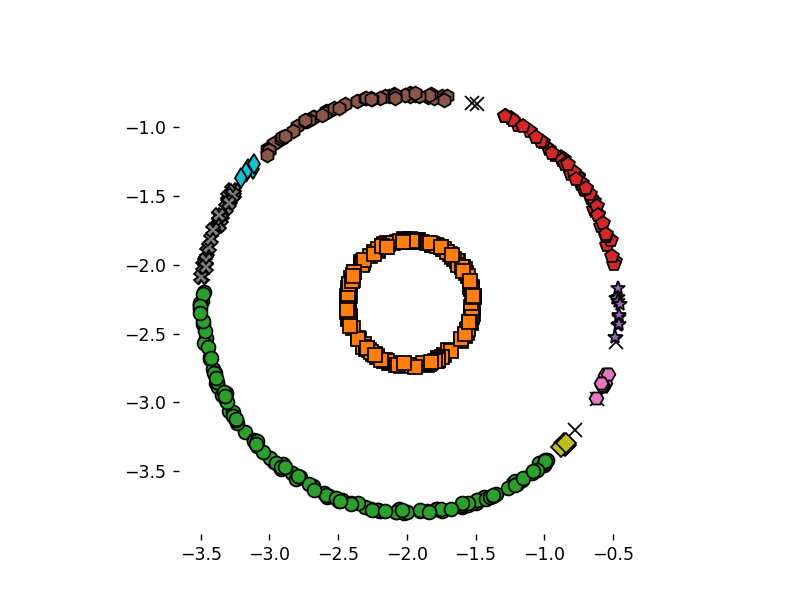

In [134]:
plot_clusters(points, labels_2, ['x', 's', 'o', 'p', '*', 'h', 'H', 'X', 'D', 'd'])

In [132]:
labels_3 = dbscan(points, 2, 3)

<IPython.core.display.Javascript object>


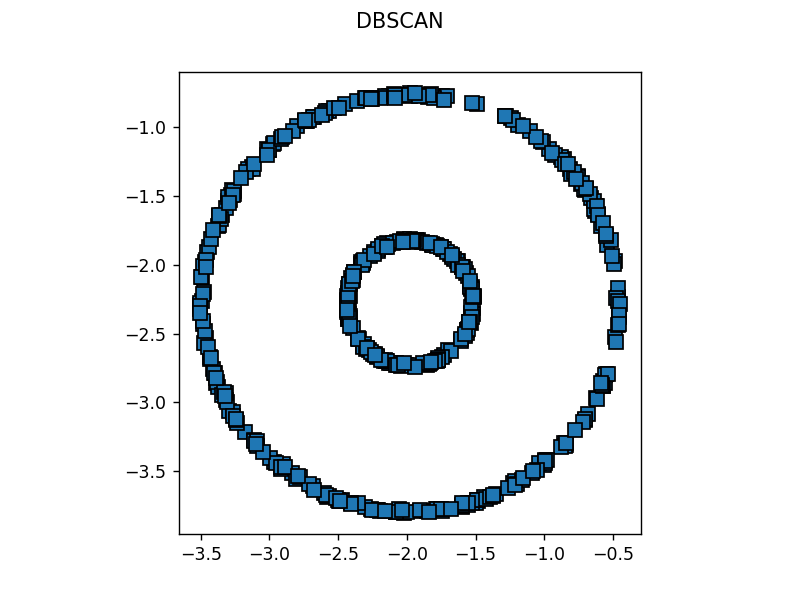

In [133]:
plot_clusters(points, labels_3, ['s', 'o', 'p', '*', 'h', 'H', 'X', 'D', 'd'])

### Spirals

In [112]:
C3 = create_spiral_cluster(random_point(10), 5, 100)

In [67]:
labels = dbscan(C3, 1, 3)

<IPython.core.display.Javascript object>


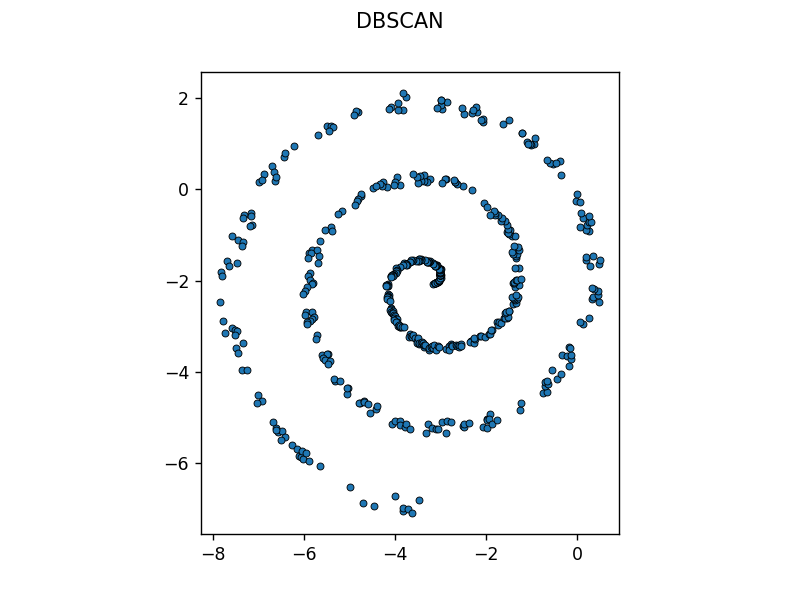

In [68]:
plot_clusters(C3, labels, ['o', 's', 'P'])

### Segments

In [19]:
P4 = random_point(10)
alpha4 = random() * math.pi / 2
C4 = create_linear_cluster(P4, 5, 100, alpha4) + create_linear_cluster((P4[0] + 1, P4[1]), 4, 100, alpha4 + 0.1)

In [20]:
labels = dbscan(C4, 0.5, 3)

<IPython.core.display.Javascript object>


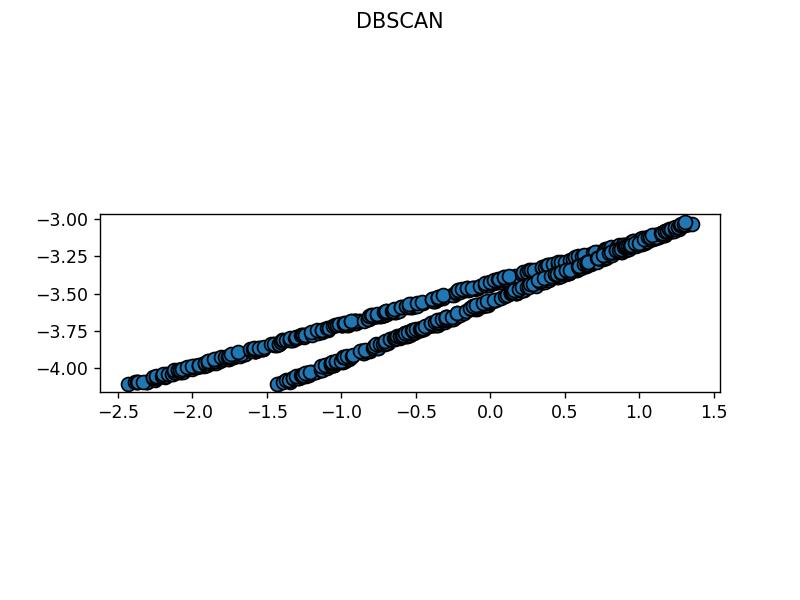

In [21]:
plot_clusters(C4, labels, ['o', 's'])

## Density

In [80]:
C5 = create_spherical_cluster((-2,0), 2, 50) + create_spherical_cluster((2,2), 0.5, 20) + create_spherical_cluster((2,0.78), 0.25, 10)

In [81]:
labels_5 = dbscan(C5, 0.5, 3)

<IPython.core.display.Javascript object>


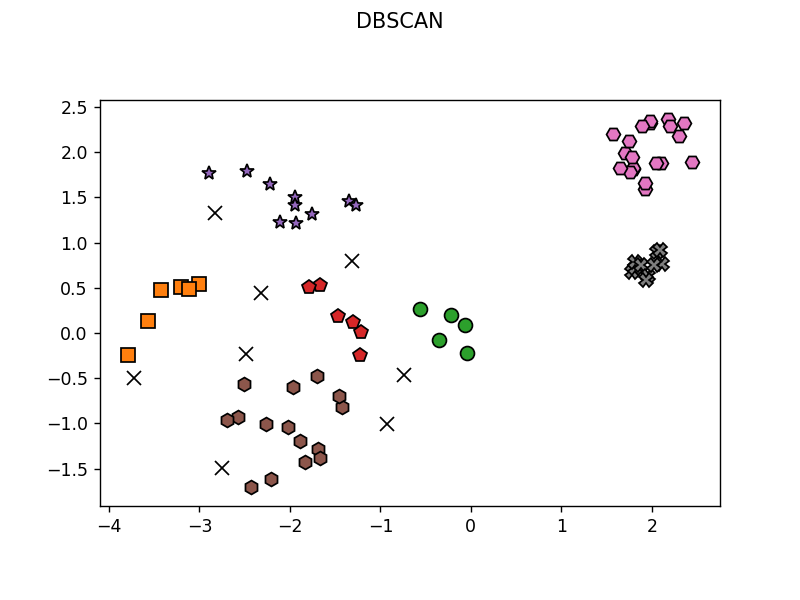

In [82]:
plot_clusters(C5, labels_5, ['s', 'o', 'p', '*', 'h', 'H', 'X', 'D', 'd'])

In [83]:
print(labels_5)

[1, 2, 3, 4, 5, 2, -1, 4, 2, 2, 2, -1, -1, 4, 5, -1, 5, 4, 5, 5, 1, -1, 5, 3, 1, 5, 5, 1, -1, 3, 5, -1, -1, 1, 4, 3, 5, 5, 4, 3, 4, 1, 5, 4, 5, 5, 3, 4, 4, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


<IPython.core.display.Javascript object>


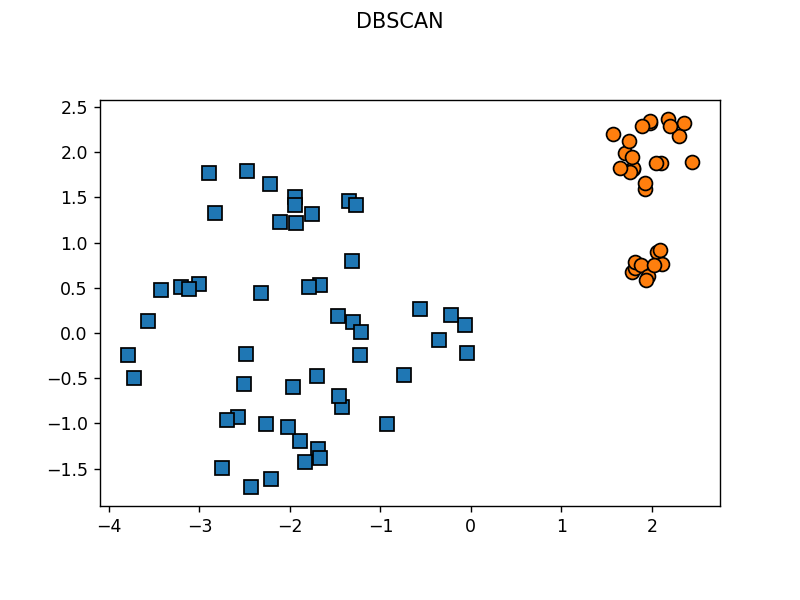

In [84]:
labels_5b = dbscan(C5, 1, 3)
plot_clusters(C5, labels_5b, ['s', 'o', 'p', '*', 'h', 'H', 'X', 'D', 'd'])

<IPython.core.display.Javascript object>


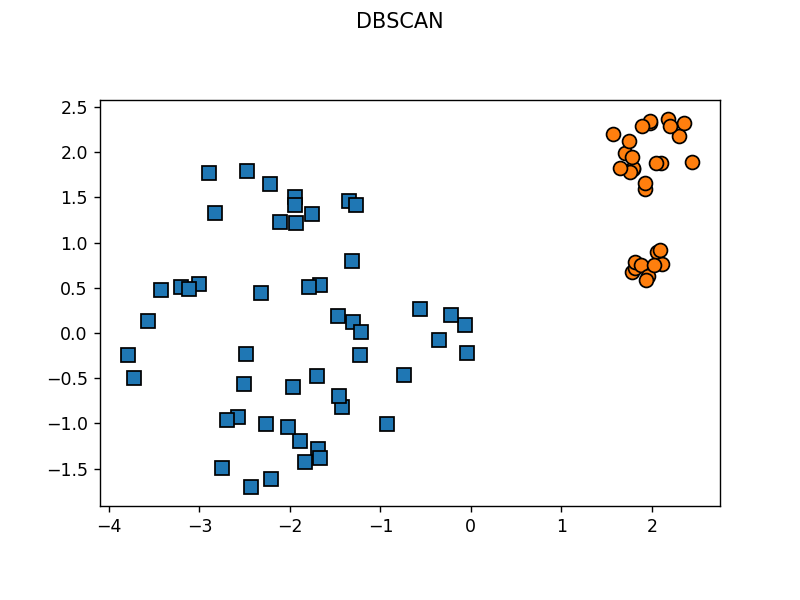

In [97]:
labels_5b = dbscan(C5, 0.69875, 3)
plot_clusters(C5, labels_5b, ['s', 'o', 'p', '*', 'h', 'H', 'X', 'D', 'd'])